# Table of Contents
 <p><div><a href="#Question-1:-Propensity-score-matching"><span class="toc-item-num">Question 1.&nbsp;&nbsp;</span>Propensity score matching</a></div>
 <ul style="list-style-type:none">
 <li><a href="#1.-A-naive-analysis"><span class="toc-item-num">1.&nbsp;&nbsp;</span>A naive analysis</a></div>
 <div class="lev1"><a href="#2.-A-closer-look-at-the-data"><span class="toc-item-num">2.&nbsp;&nbsp;</span>A closer look at the data</a></li>
 <li><a href="#3.-A-propensity-score-model"><span class="toc-item-num">3.&nbsp;&nbsp;</span>A propensity score model</a></li>
 <li><a href="#4.-Balancing-the-dataset-via-matching"><span class="toc-item-num">4.&nbsp;&nbsp;</span>Balancing the dataset via matching</a></li>
 <li><a href="#5.-Balancing-the-groups-further"><span class="toc-item-num">5.&nbsp;&nbsp;</span>Balancing the groups further</a></li>
 <li><a href="#6.-A-less-naive-analysis"><span class="toc-item-num">6.&nbsp;&nbsp;</span>Balancing the groups further</a></li>
 </ul>
 <div><a href="#Question-2:-Applied-ML"><span class="toc-item-num">Question 2.&nbsp;&nbsp;</span>Applied ML</a></div></p>

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
%matplotlib inline

## Question 1: Propensity score matching

### 1. A naive analysis

Compare the distribution of the outcome variable (re78) between the two groups, using plots and numbers. To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

We load the data from the csv file.

In [63]:
data = pd.read_csv('lalonde.csv')
data.head(2)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.046
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.894


We split the dataset into two groups, the treated and the control group, and we plot their distribution.

In [64]:
#split the dataset into groups
treated_group = data[data.treat == 1]
control_group = data[data.treat == 0]

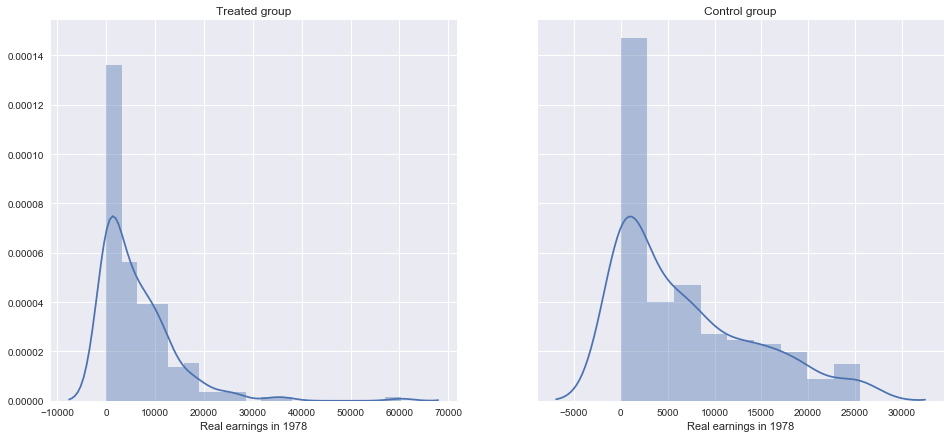

In [65]:
#plot the distribution
f, axs = plt.subplots(1,2,sharey=True, figsize=(16, 7))
sns.distplot(treated_group['re78'], ax=axs[0], axlabel='Real earnings in 1978').set_title("Treated group")
sns.distplot(control_group['re78'], ax=axs[1], axlabel='Real earnings in 1978').set_title("Control group")

We observe that in the treated group there are datapoints with very high values in the feature "real earnings in 1978". We use boxplots to check if we need to take into consideration these large values or they are oultiers.

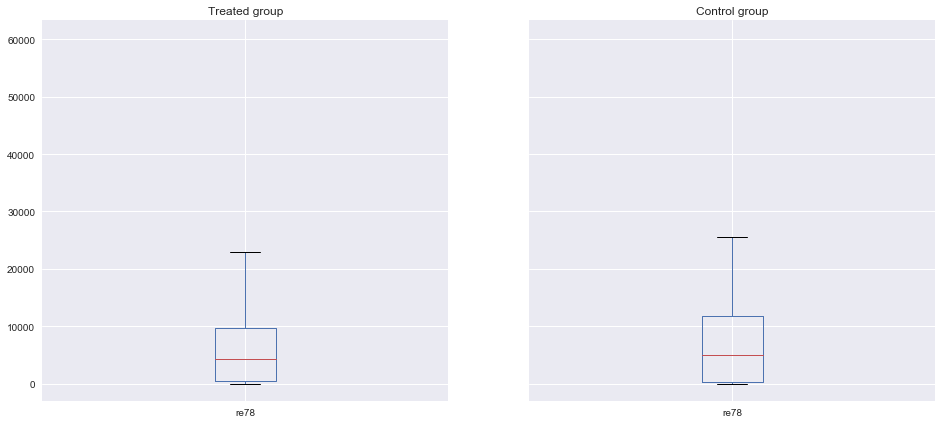

In [66]:
#plot the boxplots
f, axs = plt.subplots(1,2,sharey=True)
treated_group.plot.box(y='re78', ax=axs[0], title = 'Treated group', figsize=(16, 7), grid=True)
control_group.plot.box(y='re78', ax=axs[1], title = 'Control group', grid=True)

Our assumption is correct. These very large salary values are outliers. Hence, in this first naive approach we observe that the treated group has not better results form the control group considering the real earnings of 1978.

### 2. A closer look at the data

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

Taking the whole dataset and just considering the real earning from 1978, independently from the status, education and other aspects of the personal backgrounds is indeed naive. 
A first approach now is to consider the data from each feature, hence we are going to split the dataset into the following categories:
* Ethnicity (White, Black, Hispanic)
* Married/Non married
* Degree/Non degree
* Education years intervals
* Age intervals

<h3> Ethnicity

First we get the categories, making distinction between those who received treatment and those who did not (control)

In [67]:
black_treated = treated_group[treated_group.black == 1]
hispanic_treated = treated_group[treated_group.hispan == 1]
white_treated = treated_group[np.logical_and(treated_group.black == 0, treated_group.hispan == 0)]

black_control = control_group[control_group.black == 1]
hispanic_control = control_group[control_group.hispan == 1]
white_control = control_group[np.logical_and(control_group.black == 0, control_group.hispan == 0)]

First of all we abserve how many people are there in each group

In [68]:
white = pd.DataFrame({'Treated': white_treated.re78.describe(), 'Control': white_control.re78.describe()})
black = pd.DataFrame({'Treated': black_treated.re78.describe(), 'Control': black_control.re78.describe()})
hispanic = pd.DataFrame({'Treated': hispanic_treated.re78.describe(), 'Control': hispanic_control.re78.describe()})

In [69]:
white

,Control,Treated
count,281.000000,18.000000
mean,7617.885509,7720.992278
std,7554.486506,5564.944194
min,0.000000,0.000000
25%,675.321000,4254.658000
50%,5748.356000,5998.226500
75%,12705.490000,12582.537500
max,25564.670000,18783.350000


In [70]:
hispanic

,Control,Treated
count,61.000000,11.000000
mean,7103.843464,7122.515564
std,7042.244123,7320.482894
min,0.000000,559.443200
25%,1161.493000,3191.927000
50%,5661.171000,5112.014000
75%,9922.934000,8440.646500
max,25564.670000,26817.600000


We notice that control groups outnumber treated groups for white and hispanic people, but not for black groups showing the opposite. The mean shows that on average the treated group salary is higher, but again we need to keep in mind that the mean is not a robust measure.

Now we are going to compare the distributions, taking into consideration each "earning" occurrence with respect to the relative dataset

<h3> White

First we show separately the Control and Treated distributions, second in a stacked way and thirdly with superimposition and transparency.

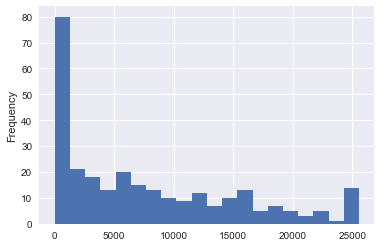

In [71]:
white_control.re78.plot.hist(bins=20)

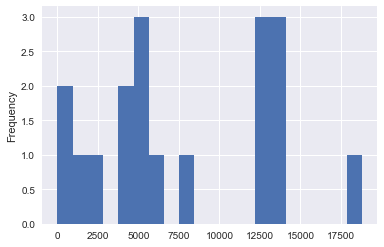

In [72]:
white_treated.re78.plot.hist(bins=20)

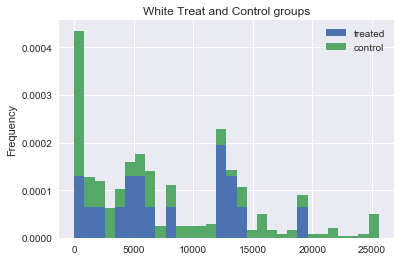

In [73]:
group_white = pd.DataFrame({'treated': white_treated.re78, 'control': white_control.re78}, columns = ['treated', 'control'])
group_white.plot.hist(stacked=True, bins=30, normed="true")
plt.title(r'White Treat and Control groups')
# 

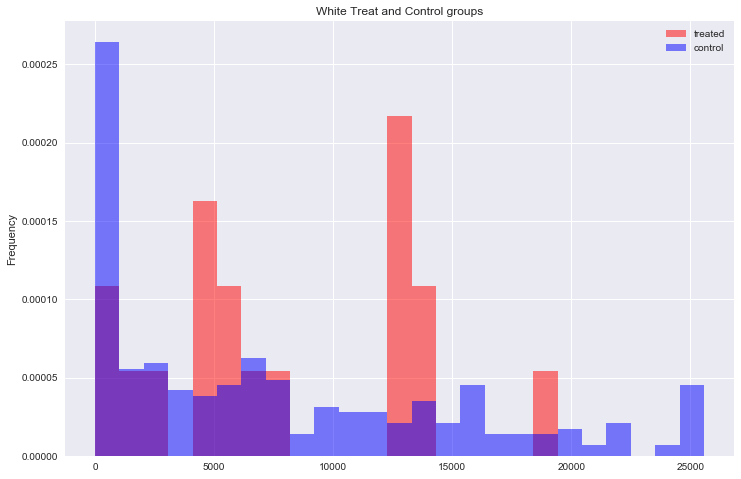

In [74]:
group_white = pd.DataFrame({'treated': white_treated.re78, 'control': white_control.re78}, columns = ['treated', 'control'])
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
group_white.plot.hist(stacked = False, ax = ax,  bins=25, normed="true", alpha=0.5, color=['r', 'b'])
plt.title(r'White Treat and Control groups')

Put in proportion, the treated white group seems to have more people with a higher salary, but stil there are more outliers with higher earnings in the control group.
Now we do the same for Black and Hispanic

<h3> Black

In [75]:
black

,Control,Treated
count,87.000000,156.000000
mean,4853.431497,6136.320647
std,6201.725283,8143.465973
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1613.677000,3879.584000
75%,8044.004500,9417.903000
max,20243.380000,60307.930000


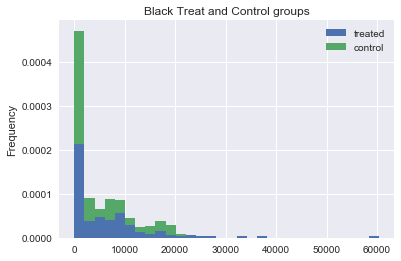

In [76]:
group_black = pd.DataFrame({'treated': black_treated.re78, 'control': black_control.re78}, columns = ['treated', 'control'])
group_black.plot.hist(stacked=True, bins=30, normed="true")
plt.title(r'Black Treat and Control groups')

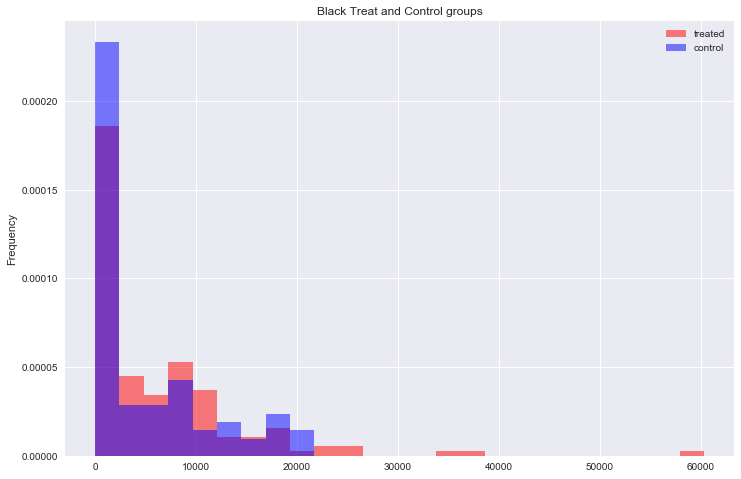

In [77]:
group_black = pd.DataFrame({'treated': black_treated.re78, 'control': black_control.re78}, columns = ['treated', 'control'])
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
group_black.plot.hist(stacked = False, ax = ax,  bins=25, normed="true", alpha=0.5, color=['r', 'b'])
plt.title(r'Black Treat and Control groups')

In [78]:
#Hispanic
hispanic

,Control,Treated
count,61.000000,11.000000
mean,7103.843464,7122.515564
std,7042.244123,7320.482894
min,0.000000,559.443200
25%,1161.493000,3191.927000
50%,5661.171000,5112.014000
75%,9922.934000,8440.646500
max,25564.670000,26817.600000


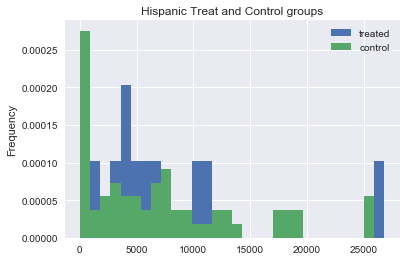

In [79]:
group_hispanic = pd.DataFrame({'treated': hispanic_treated.re78, 'control': hispanic_control.re78}, columns = ['treated', 'control'])
group_hispanic.plot.hist(stacked=False, bins=30, normed="true")
plt.title(r'Hispanic Treat and Control groups')

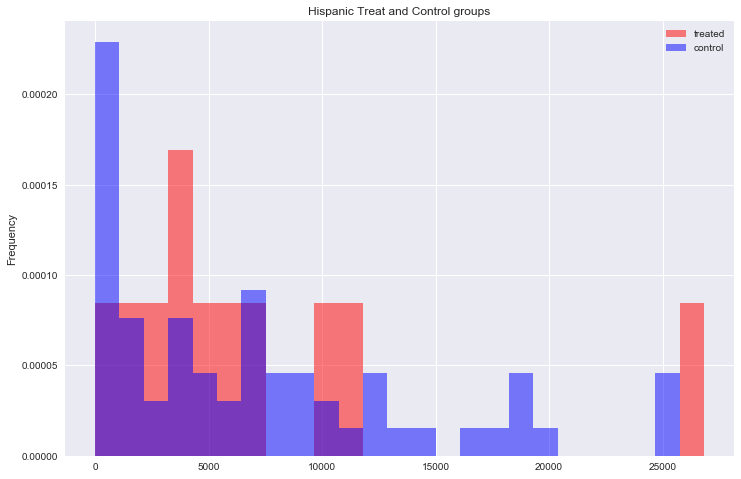

In [80]:
group_hispanic = pd.DataFrame({'treated': hispanic_treated.re78, 'control': hispanic_control.re78}, columns = ['treated', 'control'])
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
group_hispanic.plot.hist(stacked = False, ax = ax,  bins=25, normed="true", alpha=0.5, color=['r', 'b'])
plt.title(r'Hispanic Treat and Control groups')

<h3> Married/Non married

In [81]:
married_treated_group = treated_group[treated_group.married == 1]
single_treated_group = treated_group[treated_group.married == 0]

married_control_group = control_group[control_group.married == 1]
single_control_group = control_group[control_group.married == 0]

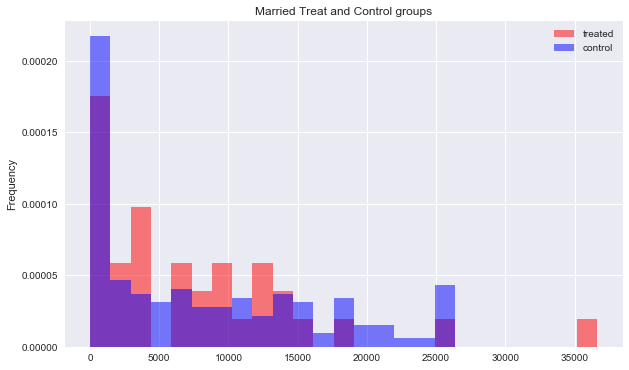

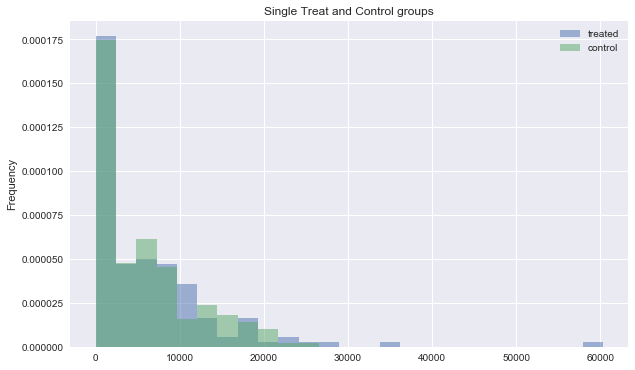

In [82]:
married_group = pd.DataFrame({'treated': married_treated_group.re78, 'control': married_control_group.re78}, columns = ['treated', 'control'])
single_group = pd.DataFrame({'treated': single_treated_group.re78, 'control': single_control_group.re78}, columns = ['treated', 'control'])
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
married_group.plot.hist(stacked = False, ax = ax,  bins=25, normed="true", alpha=0.5, color=['r', 'b'])
plt.title(r'Married Treat and Control groups')

fig = plt.figure(figsize=(10,6))
ax = fig.gca()
single_group.plot.hist(stacked = False, ax = ax,  bins=25, normed="true", alpha=0.5)
plt.title(r'Single Treat and Control groups')



In [83]:
# Description of entries
married_group.describe()

,treated,control
count,35.000000,220.000000
mean,7759.768909,8305.777044
std,8045.997583,8174.091461
min,0.000000,0.000000
25%,1517.392000,234.589100
50%,5911.551000,6337.969500
75%,11825.665000,14302.180000
max,36646.950000,25564.670000


<h3> Degree/Non degree

In [84]:
nodegree_treated = treated_group[treated_group.nodegree == 1]
degree_treated   = treated_group[treated_group.nodegree == 0]

nodegree_control = control_group[control_group.nodegree == 1]
degree_control   = control_group[control_group.nodegree == 1]

In [85]:
married_treated_group = treated_group[treated_group.married == 1]
single_treated_group = treated_group[treated_group.married == 0]

married_control_group = control_group[control_group.married == 1]
single_control_group = control_group[control_group.married == 0]

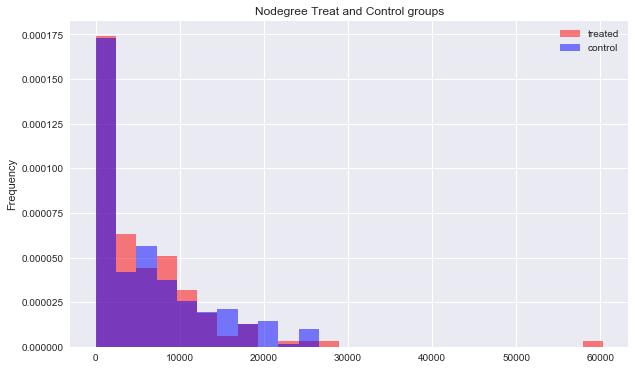

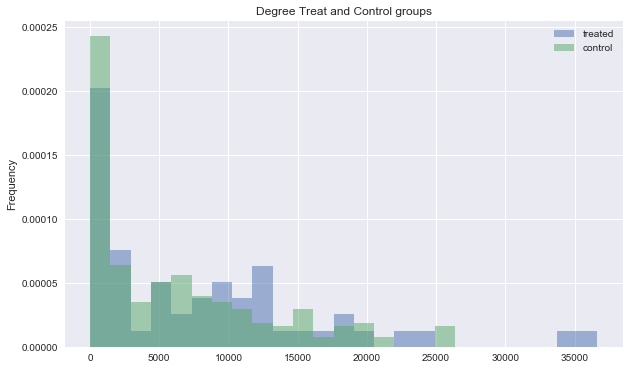

In [86]:
nodegree_group = pd.DataFrame({'treated': nodegree_treated.re78, 'control': nodegree_control.re78}, columns = ['treated', 'control'])
degree_group = pd.DataFrame({'treated': degree_treated.re78, 'control': degree_control.re78}, columns = ['treated', 'control'])
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
nodegree_group.plot.hist(stacked = False, ax = ax,  bins=25, normed="true", alpha=0.5, color=['r', 'b'])
plt.title(r'Nodegree Treat and Control groups')

fig = plt.figure(figsize=(10,6))
ax = fig.gca()
degree_group.plot.hist(stacked = False, ax = ax,  bins=25, normed="true", alpha=0.5)
plt.title(r'Degree Treat and Control groups')

<h3> Education Years Intervals

In [87]:
treated_group.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In order to create plot, classify the treated and control groups by years spent on education and calculate the mean.

In [88]:
treated_educ_less4 = treated_group.loc[treated_group["educ"]<4]
treated_educ_less4_mean = treated_educ_less4.mean()
treated_educ_less4_mean1 = treated_educ_less4_mean["re78"]

control_educ_less4 = control_group.loc[control_group["educ"]<4]
control_educ_less4_mean = control_educ_less4.mean()
control_educ_less4_mean1 = control_educ_less4_mean["re78"]

treated_educ_more4_less8 = treated_group[(treated_group['educ'] >= 4) & (treated_group['educ'] < 8)]
treated_educ_more4_less8_mean = treated_educ_more4_less8.mean()
treated_educ_more4_less8_mean1 = treated_educ_more4_less8_mean["re78"]

control_educ_more4_less8 = control_group[(control_group['educ'] >= 4) & (control_group['educ'] < 8)]
control_educ_more4_less8_mean = control_educ_more4_less8.mean()
control_educ_more4_less8_mean1 = control_educ_more4_less8_mean["re78"]

treated_educ_more8_less12 = treated_group[(treated_group['educ'] >= 8) & (treated_group['educ'] <12)]
treated_educ_more8_less12_mean = treated_educ_more8_less12.mean()
treated_educ_more8_less12_mean1 = treated_educ_more8_less12_mean["re78"]

control_educ_more8_less12 = control_group[(control_group['educ'] >= 8) & (control_group['educ'] < 12)]
control_educ_more8_less12_mean = control_educ_more8_less12.mean()
control_educ_more8_less12_mean1 = control_educ_more8_less12_mean["re78"]

treated_educ_more12_less16 = treated_group[(treated_group['educ'] >=12 ) & (treated_group['educ'] < 16)]
treated_educ_more12_less16_mean = treated_educ_more12_less16.mean()
treated_educ_more12_less16_mean1 = treated_educ_more12_less16_mean["re78"]

control_educ_more12_less16 = control_group[(control_group['educ'] >= 12) & (control_group['educ'] < 16)]
control_educ_more12_less16_mean = control_educ_more12_less16.mean()
control_educ_more12_less16_mean1 = control_educ_more12_less16_mean["re78"]

treated_educ_more16 = treated_group.loc[treated_group["educ"]>= 16]
treated_educ_more16_mean = treated_educ_more16.mean()
treated_educ_more16_mean1 = treated_educ_more16_mean["re78"]

control_educ_more16 = control_group.loc[control_group["educ"]>= 16]
control_educ_more16_mean = control_educ_more16.mean()
control_educ_more16_mean1 = control_educ_more16_mean["re78"]

Create the DataFrame by the treated group.

In [89]:
data = pd.DataFrame([{'educ mean treated values': treated_educ_less4_mean1}])
merged_mean_values = data
data1 = pd.DataFrame([{'educ mean treated values': treated_educ_more4_less8_mean1}])
merged_mean_values = merged_mean_values.append(data1)
data2 = pd.DataFrame([{'educ mean treated values': treated_educ_more8_less12_mean1}])
merged_mean_values = merged_mean_values.append(data2)
data3 = pd.DataFrame([{'educ mean treated values': treated_educ_more12_less16_mean1}])
merged_mean_values = merged_mean_values.append(data3)
data4 = pd.DataFrame([{'educ mean treated values': treated_educ_more16_mean1}])
merged_mean_values1 = merged_mean_values.append(data4)

Create the DataFrame by the control group.

In [90]:
data = pd.DataFrame([{'educ mean control values': control_educ_less4_mean1}])
merged_mean_values = data
data1 = pd.DataFrame([{'educ mean control values': control_educ_more4_less8_mean1}])
merged_mean_values = merged_mean_values.append(data1)
data2 = pd.DataFrame([{'educ mean control values': control_educ_more8_less12_mean1}])
merged_mean_values = merged_mean_values.append(data2)
data3 = pd.DataFrame([{'educ mean control values': control_educ_more12_less16_mean1}])
merged_mean_values = merged_mean_values.append(data3)
data4 = pd.DataFrame([{'educ mean control values': control_educ_more16_mean1}])
merged_mean_values2 = merged_mean_values.append(data4)

Merged the two Dataframes

In [91]:
merged_mean_values1['educ mean control values'] = merged_mean_values2
age_groups = pd.DataFrame({'age groups': [['0-4'],['4-8'],['8-12'],['12-16'],['16+']]})
merged_mean_values1 = merged_mean_values1.reset_index(drop=True)
merged_mean_values1['age groups'] = age_groups
merged_mean_values1 = merged_mean_values1.set_index('age groups')

Create the plot by the Education years

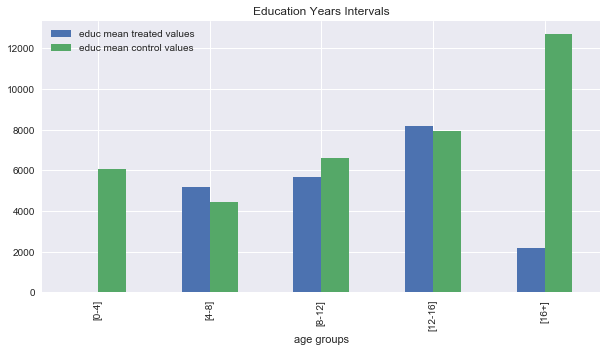

In [92]:
#merged_mean_values1.plot.bar()
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
merged_mean_values1.plot.bar(ax = ax)
plt.title(r'Education Years Intervals')

<h3> Age Intervals

In order to create plot, classify the treated and control groups by age and calculate the mean.

In [93]:
treated_age_less18 = treated_group.loc[treated_group["age"]<18]
treated_age_less18_mean = treated_age_less18 .mean()
treated_age_less18_mean1 = treated_age_less18_mean["re78"]

control_age_less18 = control_group.loc[control_group["age"]<18]
control_age_less18_mean = control_age_less18.mean()
control_age_less18_mean1 = control_age_less18_mean["re78"]

treated_age_more18_less25 = treated_group[(treated_group['age'] >= 18) & (treated_group['age'] < 25)]
treated_age_more18_less25_mean = treated_age_more18_less25.mean()
treated_age_more18_less25_mean1 = treated_age_more18_less25_mean["re78"]

control_age_more18_less25 = control_group[(control_group['age'] >= 18) & (control_group['age'] < 25)]
control_age_more18_less25_mean = control_age_more18_less25.mean()
control_age_more18_less25_mean1 = control_age_more18_less25_mean["re78"]

treated_age_more25_less35 = treated_group[(treated_group['age'] >= 25) & (treated_group['age'] < 35)]
treated_age_more25_less35_mean = treated_age_more25_less35.mean()
treated_age_more25_less35_mean1 = treated_age_more25_less35_mean["re78"]

control_age_more25_less35 = control_group[(control_group['age'] >= 25) & (control_group['age'] < 35)]
control_age_more25_less35_mean = control_age_more25_less35.mean()
control_age_more25_less35_mean1 = control_age_more25_less35_mean["re78"]

treated_age_more35_less45 = treated_group[(treated_group['age'] >=35 ) & (treated_group['age'] < 45)]
treated_age_more35_less45_mean = treated_age_more35_less45.mean()
treated_age_more35_less45_mean1 = treated_age_more35_less45_mean["re78"]

control_age_more35_less45 = control_group[(control_group['age'] >= 35) & (control_group['age'] < 45)]
control_age_more35_less45_mean = control_age_more35_less45.mean()
control_age_more35_less45_mean1 = control_age_more35_less45_mean["re78"]

treated_age_more45 = treated_group.loc[treated_group["age"]>= 45]
treated_age_more45_mean = treated_age_more45.mean()
treated_age_more45_mean1 = treated_age_more45_mean["re78"]

control_age_more45 = control_group.loc[control_group["age"]>= 45]
control_age_more45_mean = control_age_more45.mean()
control_age_more45_mean1 = control_age_more45_mean["re78"]

Create the DataFrame by the control group.

In [94]:
data = pd.DataFrame([{'age mean control values': control_age_less18_mean1}])
merged_mean_values = data
data1 = pd.DataFrame([{'age mean control values': control_age_more18_less25_mean1}])
merged_mean_values = merged_mean_values.append(data1)
data2 = pd.DataFrame([{'age mean control values': control_age_more25_less35_mean1}])
merged_mean_values = merged_mean_values.append(data2)
data3 = pd.DataFrame([{'age mean control values': control_age_more35_less45_mean1}])
merged_mean_values = merged_mean_values.append(data3)
data4 = pd.DataFrame([{'age mean control values': control_age_more45_mean1}])
merged_mean_values1 = merged_mean_values.append(data4)

Create the DataFrame by the treated group.

In [95]:
data = pd.DataFrame([{'age mean treated values': treated_age_less18_mean1}])
merged_mean_values = data
data1 = pd.DataFrame([{'age mean treated values': treated_age_more18_less25_mean1}])
merged_mean_values = merged_mean_values.append(data1)
data2 = pd.DataFrame([{'age mean treated values': treated_age_more25_less35_mean1}])
merged_mean_values = merged_mean_values.append(data2)
data3 = pd.DataFrame([{'age mean treated values': treated_age_more35_less45_mean1}])
merged_mean_values = merged_mean_values.append(data3)
data4 = pd.DataFrame([{'age mean treated values': treated_age_more45_mean1}])
merged_mean_values2 = merged_mean_values.append(data4)

Merged the two Dataframes

In [96]:
merged_mean_values1['educ mean control values'] = merged_mean_values2
age_groups = pd.DataFrame({'age groups': [['0-4'],['4-8'],['8-12'],['12-16'],['16+']]})
merged_mean_values1 = merged_mean_values1.reset_index(drop=True)
merged_mean_values1['age groups'] = age_groups
merged_mean_values1 = merged_mean_values1.set_index('age groups')

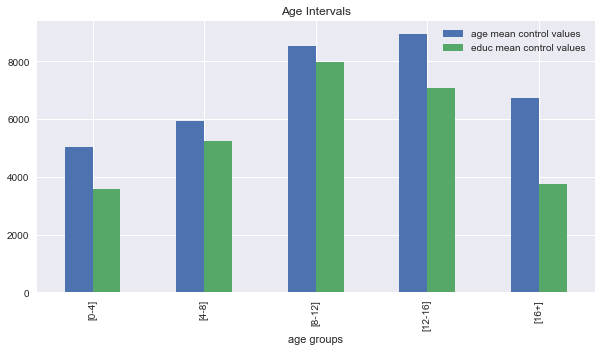

In [97]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
merged_mean_values1.plot.bar(ax = ax)
plt.title(r'Age Intervals');

### 3. A propensity score model

The propensity score is the conditional probability of treatment Z = 1 given the observed covariates x, e(x) = Pr(Z = 1| x). In our case, treatment assignment is represented with the feature "treat" and the observed covariates are the pre-treatment features.

In [98]:
data = pd.read_csv('lalonde.csv')
# add column white
data['white'] = 0

# moving the column "white" next to "hispan" for better representation
cols = data.columns.tolist()
cols = cols[:6] + cols[-1:] + cols[6:-1]
data = data[cols]

# set white = 1 when the person is not black neither hispan
data.white[np.logical_and(data.black == 0, data.hispan == 0)] = 1

data.head(2)

,id,treat,age,educ,black,hispan,white,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,0,1,1,0.0,0.0,9930.046
1,NSW2,1,22,9,0,1,0,0,1,0.0,0.0,3595.894


We create the features and class vectors (X and y)

In [99]:
feature_cols = ['age', 'educ', 'black', 'hispan', 'white', 'married','nodegree','re74','re75']
X = data[feature_cols]
y = data.treat

We use logistic regression to train the model

In [100]:
# Logistic regression to estimate propensity scores for all points in the dataset
logistic = linear_model.LogisticRegression() 

# To fit the logistic regression model and apply it to each data point to obtain propensity scores
logistic.fit(X, y) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

The matrix 'pred' below shows the probability of each data point belonging to the treated (1st column) or control group (2nd column).

In [101]:
pred = logistic.predict_proba(X)
pred

array([[ 0.48723672,  0.51276328],
       [ 0.7061392 ,  0.2938608 ],
       [ 0.35144998,  0.64855002],
       ..., 
       [ 0.88237872,  0.11762128],
       [ 0.4383438 ,  0.5616562 ],
       [ 0.84972247,  0.15027753]])

Propensity score of a data point represents its probability of receiving the treatment. Therefore, we add the 1st column to the DataFrame

In [102]:
data['propensity_score'] = pred[:,1]
data.tail(20)

,id,treat,age,educ,black,hispan,white,married,nodegree,re74,re75,re78,propensity_score
594,PSID410,0,42,16,0,0,1,0,0,0.0,0.0,23764.8000,0.094527
595,PSID411,0,18,10,1,0,0,0,1,0.0,0.0,5306.5160,0.698739
596,PSID412,0,53,12,1,0,0,0,0,0.0,0.0,0.0000,0.573974
597,PSID413,0,17,10,0,0,1,1,1,0.0,0.0,3859.8220,0.093091
598,PSID414,0,17,6,0,0,1,0,1,0.0,0.0,0.0000,0.156846
599,PSID415,0,43,6,0,0,1,1,1,0.0,0.0,0.0000,0.072665
600,PSID416,0,34,12,1,0,0,0,0,0.0,0.0,0.0000,0.635981
601,PSID417,0,16,8,0,1,0,0,1,0.0,0.0,12242.9600,0.315780
602,PSID418,0,27,12,0,0,1,1,0,0.0,0.0,1533.8800,0.077434
603,PSID419,0,51,4,1,0,0,0,1,0.0,0.0,0.0000,0.626767


### 4. Balancing the dataset via matching

Matching the elements belonging to the treated set to those belonging to the control set while minimizing the total absolute difference between their respective propensity scores is equivalent to solving the maximum weight matching problem (in our case minimum), which can be solved using the Hungarian or Kuhn-Munkres algorithm.<br>
If we define a cost matrix c_m as the matrix having as many rows as #people in treated group, having as many columns as #people in control group, and each entry being the absolute difference between propensity scores belonging to treated and control people, then we can solve this as a linear sum assignment problem.<br>
For this purpose we can use the linear_sum_assignment method from scipy.

In [103]:
from scipy.optimize import linear_sum_assignment

We realize our Match() function which will take the dataset with treat== 1 or 0 and the propensity scores:<br>
1- it separates elements of propensity according to whether they are treated or control<br>
2- creates an empty matrix which will be the cost matrix (with all the absolute differences)<br>
3- creates a matches array which will have two sub-arrays, with the elements from treated matched to those in control orderedly<br>
4- returns the matches array and the cost matrix (which has been used for private checks)

In [104]:
def Match(groups, propensity):
     
    # Compute the length of two groups
    # Code two groups(control group, treated group) as 0 and 1
    #groups = groups == groups.unique()[0]
    groups_length = len(groups)
    treated_group_length = groups.sum()
    control_group_length = groups_length-treated_group_length
    propensity_treated, propensity_control = propensity[groups == 1], (propensity[groups == 0])
    # The length of treated group is 185 and length of control group is 614-185=429 so we need to fill the empty space by NAN

    # the cost matrix c_m initialized to zero
    c_m = np.zeros((treated_group_length, control_group_length))
    # The match array
    matches = pd.Series(np.empty(treated_group_length))
    
    # Here we fill the cost matrix, originally every entry has 0, then we add the distance to each of them
    # obtaining the final cost matrix, this will be given to the linear_sum_assignment method which will return
    # two arrays,  one with the row indices and other with the corresponding column indices,
    # giving the optimal assignment
    
    for i in range(treated_group_length):
        distance = abs(propensity_treated[i] - propensity_control)
        # the entries of c_m == 0, adding the distance means that we store those distances for each element in treated
        c_m[i] = c_m[i] + distance
        
    # here we use the linear sum assignment method to get the array of matches    
    matches = linear_sum_assignment(c_m)
    return matches, c_m

Length of all group (treated group and control group)

In [105]:
groups_length = len(data.treat)
groups_length

614

Length of the treated group

In [106]:
data.treat.sum()

185

Matching the propensity scores:

In [107]:
# we initialize a new matrix c_matr with N rows (number of treat values) and D columns (number of ) just for private checks
c_matr = np.zeros((data.treat.sum(), groups_length))

# And we run the match function, which will return 2 arrays with the matching Treat and relative Control and the cost matrix #just used to check correctness 
matching, c_matr = Match(data.treat, data.propensity_score)

Since we want to take all the control rows from the original dataset "data", we notice that linear_sum_assignment used inside our Match() function returned the matching with a indexing starting from 0 and not 185, so to get the correct control rows we just sum 185 (or equivalently data.treat.sum())

In [108]:
control_indexes = matching[1] + data.treat.sum()

In [109]:
# Get the portion of data that we matched earlier
control_selection = data.iloc[control_indexes]

Here just to make sure that the elements having treat == 1 and being processes inside the method Match() are considered, we get from data the list of these elements with iloc.

In [110]:
treat_selection = data.iloc[matching[0]]

Now let's have a look at the following features with the matched set:
* Earnings from 1974 and 1975
* Earnings from 1978
* White 
* Black 
* Hispanic

<h3> Earnings from 1974 and 1975

Now lets compare these two groups:

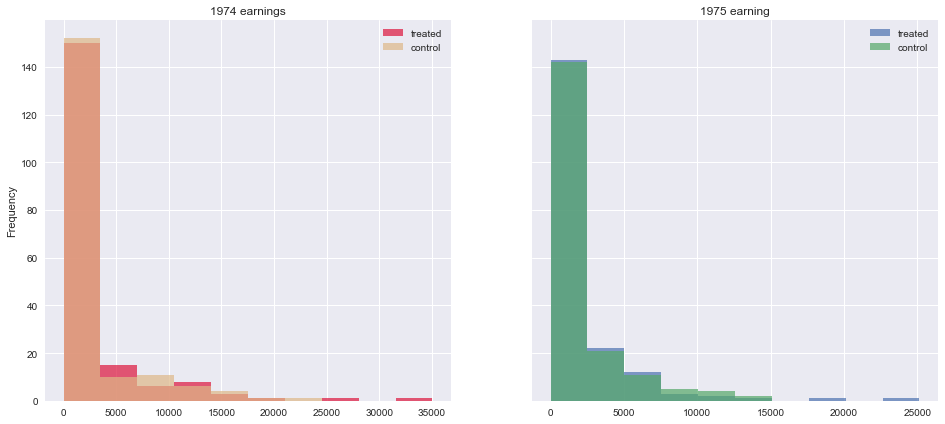

In [111]:
total_selection74 = pd.DataFrame({'treated': treat_selection.re74, 'control': control_selection.re74}, columns = ['treated', 'control'])
total_selection75 = pd.DataFrame({'treated': treat_selection.re75, 'control': control_selection.re75}, columns = ['treated', 'control'])

f, axs = plt.subplots(1,2,sharey=True)
total_selection74.plot.hist(ax=axs[0], title = '1974 earnings', figsize=(16, 7), grid=True, alpha=0.7, color=['crimson', 'burlywood'],)
total_selection75.plot.hist(ax=axs[1], title = '1975 earning', grid=True, alpha=0.7);

<h3> Earnings from 1978

First we plot the boxplots

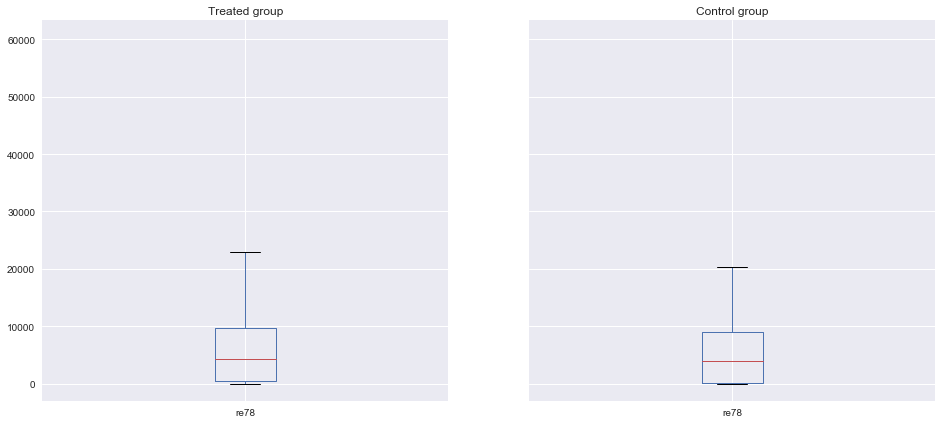

In [112]:
#plot the boxplots
f, axs = plt.subplots(1,2,sharey=True)
treat_selection.plot.box(y='re78', ax=axs[0], title = 'Treated group', figsize=(16, 7), grid=True)
control_selection.plot.box(y='re78', ax=axs[1], title = 'Control group', grid=True)

Then the barplots

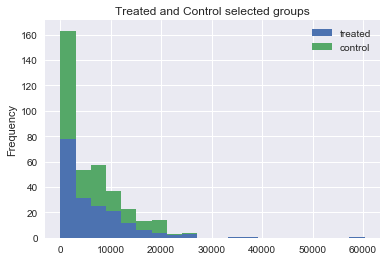

In [113]:
total_selection = pd.DataFrame({'treated': treat_selection.re78, 'control': control_selection.re78}, columns = ['treated', 'control'])
# In this case adding normed="True" naturally brings no change to the plot 
total_selection.plot.hist(stacked=True, bins=20)
plt.title(r'Treated and Control selected groups');

And the barplots side by side

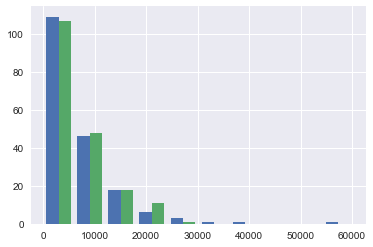

In [114]:
# The blue bars refer to treated and the green ones to control
plt.hist([treat_selection.re78, control_selection.re78], bins=10);

We notice from the two plots that the treated group has outliers with much higher 1978's earnings 

<h3> White

In [115]:
## White which is black==0 and hispanic==0
select_white_treat = treat_selection[np.logical_and(treat_selection.hispan == 0, treat_selection.black == 0 )]
select_white_control = control_selection[np.logical_and(control_selection.hispan == 0, control_selection.black == 0 )]

select_white_treat.re78.describe()

count       18.000000
mean      7720.992278
std       5564.944194
min          0.000000
25%       4254.658000
50%       5998.226500
75%      12582.537500
max      18783.350000
Name: re78, dtype: float64

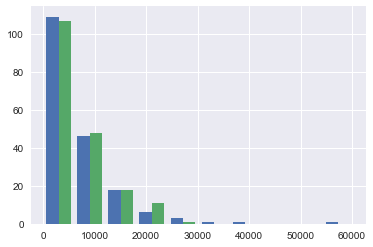

In [116]:
plt.hist([treat_selection.re78, control_selection.re78], bins=10);

<h3> Black & Hispanic

In [117]:
# black
select_black_treat = treat_selection[treat_selection.black ==1]
select_black_control = control_selection[control_selection.black == 1]

# hispanic
select_hispanic_treat = treat_selection[treat_selection.hispan == 1]
select_hispanic_control = control_selection[control_selection.hispan == 1]

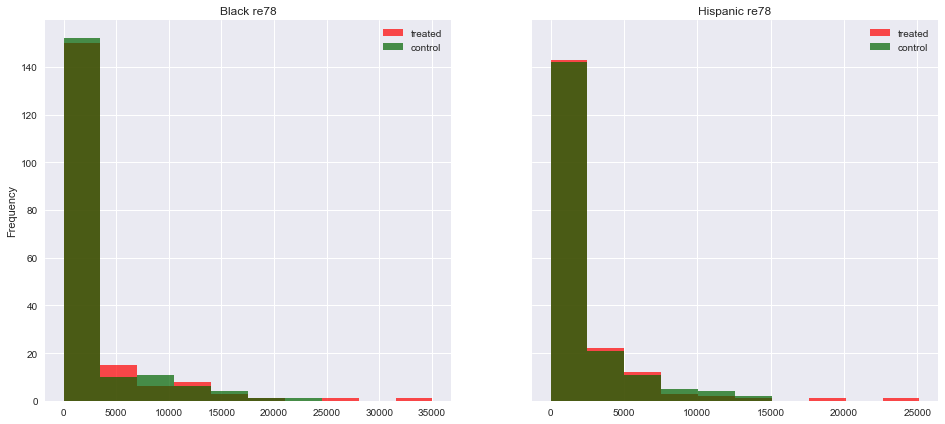

In [118]:
total_black = pd.DataFrame({'treated': select_black_treat.re78, 'control': select_black_control.re78}, columns = ['treated', 'control'])
total_hispanic = pd.DataFrame({'treated': select_hispanic_treat.re78, 'control': select_hispanic_control.re78}, columns = ['treated', 'control'])

f, axs = plt.subplots(1,2,sharey=True)
total_selection74.plot.hist(ax=axs[0], title = 'Black re78', figsize=(16, 7), grid=True, alpha=0.7, color=['red', 'darkgreen'])
total_selection75.plot.hist(ax=axs[1], title = 'Hispanic re78', grid=True, alpha=0.7, color=['red','darkgreen'],);

In [119]:
select_black_treat.re78.describe()

count      156.000000
mean      6136.320647
std       8143.465973
min          0.000000
25%          0.000000
50%       3879.584000
75%       9417.903000
max      60307.930000
Name: re78, dtype: float64

In [120]:
select_black_control.re78.describe()

count       87.000000
mean      4853.431497
std       6201.725283
min          0.000000
25%          0.000000
50%       1613.677000
75%       8044.004500
max      20243.380000
Name: re78, dtype: float64

What we observe is a slightly better allineation in the Treated-Control frequencies for 1978 Earning, White and Hispanic, but for the Black Ethnicity group there seem to be more people earning more among those belonging to the Control set than in the Treat set, but probably this is due to the fact that there are 156 people in Treat and only 87 in Control.<br>
There's the need to refine the analysis to draw better conclusions.

### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching? Would you say your dataset is sufficiently balanced? If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature. Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

We are not fully satisfied with the matching and as noticed in the previous task there is at least one group which is unbalanced.<br> Now the aim is to balance the problematic feature set by having an exact match Control-Treat, with in total only 87 + 87 elements 

The method is follows this procedure:
- find the treated elements from the total treated group
- find the ones which were matched to select_black_control through their position in the matching array (it's enough to know the position since it corresponds to the values of treated set.
- erase the 156-87 values
- compute 5 and 6

### 6. A less naive analysis

Compare the outcomes (re78) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.<br> What do you conclude about the effectiveness of the job training program?

## Question 2: Applied ML

In [121]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

### 1. Load the 20newsgroup dataset

We download the the data archive from the original 20 newsgroups website and we extract the archive contents in the ~/scikit_learn_data/20news_home folder. Then we load the training set folder.

In [122]:
# Download the dataset
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

The data is organized into 20 different newsgroups, each corresponding to a different topic

In [123]:
# example of the first 3 categories
newsgroups_train.target_names[:3]

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc']

In [124]:
# The number of the files included in the taining set
len(newsgroups_train.data)

11314

In [125]:
# The target attribute is the integer index of the category:
newsgroups_train.target[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

In [126]:
# Sample of the articles included in the dataset
newsgroups_train.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In order to classify the news we turn the text into vectors of numerical values. We extract TF-IDF vectors of unigram tokens from the dataset

In [127]:
# The vectorizer extracts TF-IDF vectors
vectorizer = TfidfVectorizer()

# A vector is created for every document of the dataset
# fit_transform() returns tf-idf-weighted document-term matrix.
vectors = vectorizer.fit_transform(newsgroups_train.data) 
vectors.shape

(11314, 130107)

Now we have to split our dataset into 3 subsets, 80% train set, 10% validation set and 10% set. In the 2nd task we are going to use the method GridSearchCV() to fine-tune two parameters. By working on Question2, we concluded that it is more convenient for the implementation of the task to split now the initial data set only into train (90%) and test (10%), and to define our validation set when we call the method GridSearchCV(). That is because we cannot give as input the a completely separate set in GridSearchCV() for crossvalidation

We also keep paired the documents of each subset with their corresponding labels (article category)

In [128]:
# the features are the tf-idf values. One entry per document
X = vectors
# Document's labels 
y = newsgroups_train.target[:]

# we split the train set into subsets. 90% will be used for training and the rest 10% for validation and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10) 

### 2. Train a random forest on your training set

We train a Random Forest in our trainning set. We also test the performance of our classifier with some random intial values for the estimator "n_estimators" and the max depth of the trees "max_depth" to decide about the area we want to apply the grid search. We observe that for n_estimators = 50 and max_depth = 20, the returned score is very low and we choose to extend the search to higher values.

In [ ]:
clf = RandomForestClassifier(n_estimators = 50, max_depth = 20)
clf = clf.fit(X_train, y_train)

scores = cross_val_score(clf, X_test, y_test)
scores.mean()

0.55588790641982133

We use a grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth" to fine-tune the parameters of our predictor on your validation set. We decided to test the different values of the parameters according to the accuracy scores that we get from the cross validation. The cross validaiton set is defined by the attribute "cv" of the GridSearchCV(). cv=10 means 1 out of 10 data points will be used for validation, thus 10% of the training set.

In [ ]:
# the range of the values to be investigated in the grid search
num_of_trees = range(100,200,25)
maximum_depth = range(30,50,10)


# Set the parameters to be tested
tuned_parameters = [{'n_estimators': num_of_trees, 'max_depth': maximum_depth}]

# evaluate based on accuracy metric 
scores = ['accuracy']

# the  for loop enables the option to check for more than one metrics if needed
for score in scores:
    print("---- Tune the parameters for", score, "metric ----\n")
    
    
    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, n_jobs=-1)
    clf.fit(X_train, y_train)

    print("The best set of parameters found is:\n")
    print(clf.best_params_, "\n")
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

---- Tune the parameters for accuracy metric ----



Now we create the confusion matrix. It is about a specific table layout that allows visualization of the performance of our predictor. Each column of the matrix represents the instances in a predicted class while each row represents the instances in an actual class (or vice versa).

In [ ]:
# The best values as defined from the grid search
best_estimator = clf.best_params_['n_estimators']
best_depth = clf.best_params_['max_depth']

# The classifier is trained according to the best values
clf_final = RandomForestClassifier(n_estimators = 30, max_depth = 10)
clf_final = clf_final.fit(X_train, y_train)

# The prediction of the classifier on the test set
y_pred = clf_final.predict(X_test)

# The confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred,)

A graphical representation of the Confusion Matrix presents in a more understandable way the performance of our predictor 

In [ ]:
plt.figure(figsize=(12, 12))
plt.title('Confusion matrix')
sns.heatmap(conf_matrix, cmap='YlGn', annot=True)
plt.xticks(np.arange(len(newsgroups_train.target_names)), newsgroups_train.target_names, rotation=90)
plt.yticks(np.arange(len(newsgroups_train.target_names)), newsgroups_train.target_names, rotation=0)
plt.show()

When run the method will return the values 200 and 50 as optimal (if there's no output please run it on your machine) thanks.